# Modelling the absorber distribution

In [1]:
import numpy as np
from scipy.integrate import quad, simps, quadrature, romb, romberg
from scipy.optimize import curve_fit
from scipy import interpolate as interp
from compos import const, matterps as mps, growthfactor as gf
from astropy.units.astrophys import Mpc, M_sun
import astropy.units as u
from pkg_resources import resource_filename
from astropy.constants import G as grav
from astropy.table import Table
from MgIIabs.model import halomassfunc as hmf, halomodel as hmod, absdistrib as ad
import matplotlib.pyplot as plt
import pdb
from scipy.special import ndtr

import cProfile
import time

In order to get $d^2N/dW_rdl$, we need to perform the following integral:
$$
\int_{M_{low}}^{\infty}dM\frac{dN}{dM}\pi R_g^2P(W_r|M)
$$
Where $M_{low}$  is decided by the rest equivalent width we are interested in. It can be obtained from `hmod.lowest_mass`. I have decided to work in units of $10^{12}M_\odot$. Unfortunately, it is very costly computing this integrand (even though there has been around a factor 10 speedup since my original code). 

I have transformed to semi logarithmic space (`y = log10(M)`). This transformation means the integrand gets another factor of $\ln(10)M$. The reason for this is made apparent in the following steps

In [2]:
def integrand(logM_12,rew):
    M = 10**logM_12*1e12
    dndm = hmf.dNdM(M*M_sun,z=z,growthf=growthf)*rho_m/M**2#Because of the way dN/dm is coded
    sigmag = np.pi*hmod.rg(M*M_sun,z=z).value**2
    pWM = hmod.p_rew_given_m(rew,M*M_sun,z=z)[0].value
    return dndm*sigmag*pWM*M

In [4]:
rew = 0.1*u.nm
z = 0
growthf=gf.growfunc_z(z)

M_low = np.log10(hmod.lowest_mass(rew,z=z,low=0).value/1e12) #logarithmic mass in units of 1e12 Msun
M_high = 4

#Cosmological parameters
const.initializecosmo()
H0 = 100*u.km/u.s/u.Mpc #(units of h km/s/Mpc)
rho_cr0 = 3*H0**2/(8*np.pi*grav)
rho_m0 = const.cosmo['omega_0']*rho_cr0
rho_m = rho_m0.to(M_sun/Mpc**3).value*(1+z)**3

-4.90262066058 4


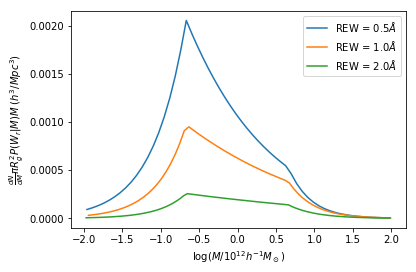

In [5]:
print(M_low,M_high)
plt.figure()
for rew in [0.05*u.nm,0.1*u.nm,0.2*u.nm]:
    M_low = np.log10(hmod.lowest_mass(rew,z=z,low=0).value/1e12) #logarithmic mass in units of 1e12 Msun
    M_high = 4
    M12array = np.linspace(M_low-0.01*M_low,M_high,150)
    integ = []
    for mass in M12array:
        integ.append(integrand(mass,rew)*np.log(10))#Bringing in that factor of log(10)
    plt.plot(M12array,integ, label="REW = {:1.1f}$\AA$".format(rew.value*10))
plt.legend()
plt.ylabel(r"$\frac{dN}{dM}\pi R_g^2P(W_r|M)M$ $(h^3/Mpc^3)$")
plt.xlabel(r"$\log(M/10^{12} h^{-1}M_\odot)$")
plt.show()

This is a rather wierd shape. Possibly because I'm extraplolating $\kappa_g$. I need to explore this. Interestingly, Tinker and Chen mention some similar shape in Fig 3. There seems to be something off about the amplitude of the function though

### $\kappa_g$

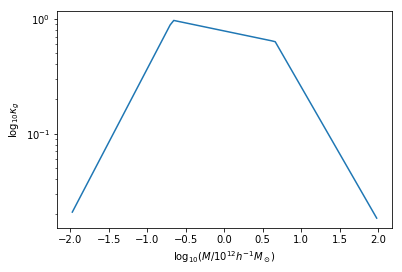

In [8]:
kappagrid = hmod.kappa_g(10**M12array*1e12*M_sun)
plt.figure()
plt.semilogy(M12array,kappagrid)
plt.ylabel("$\log_{10}\kappa_g$")
plt.xlabel("$\log_{10}(M/10^{12} h^{-1}M_\odot)$")
plt.show()

## Fitting a gaussian to the integrand for $d^2N/dW_rdl$

[-0.22058536  0.66040028  0.00121304]


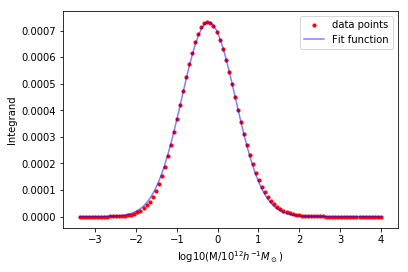

In [62]:
def gauss(x,mu,sigma,A):
    return A/np.sqrt(2*np.pi)/sigma*np.exp(-(x-mu)**2/(2*sigma**2))
guess = [-1,2,3e-4]
popt, pcov = curve_fit(gauss,M12array,integ,p0=guess)
print(popt)

muopt = popt[0]
sigmaopt = popt[1]
Aopt = popt[2]

fit = gauss(M12array,muopt,sigmaopt,Aopt)

fit_plot = plt.plot(M12array,fit,label="Fit function",color="blue",alpha=0.5)[0]
data_points = plt.scatter(M12array,integ,s=10,color='red',label="data points")
plt.xlabel(r"log10(M/$10^{12}h^{-1} M_\odot$)")
plt.ylabel(r"Integrand")
plt.legend(handles=[data_points,fit_plot])
plt.show()

### Redshift dependence

We can perform the same excercise for higher redshifts. The highest I'm interested in is 2.5. Now I needn't worry about REW because it only decides $M_{low}$. Since I need REW above 0.1 nm anyway, let's see the same plot for z = 2.5

-7.34290826715 4
[-0.49202553  0.63911422  0.00726843]


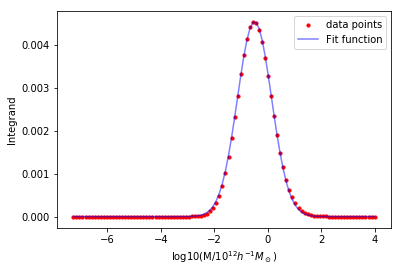

In [64]:
z = 2.5
growthf=gf.growfunc_z(z)

M_low = np.log10(hmod.lowest_mass(rew,z=z,low=3).value/1e12) #logarithmic mass in units of 1e12 Msun
M_high = 4

#Cosmological parameters
const.initializecosmo()
H0 = 100*u.km/u.s/u.Mpc #(units of h km/s/Mpc)
rho_cr0 = 3*H0**2/(8*np.pi*grav)
rho_m0 = const.cosmo['omega_0']*rho_cr0
rho_m = rho_m0.to(M_sun/Mpc**3).value*(1+z)**3

#Computing the integral
print(M_low,M_high)
M12array = np.linspace(M_low-0.01*M_low,M_high,100)
integ = []
for mass in M12array:
    try:
        integ.append(integrand(mass)*np.log(10))#Bringing in that factor of log(10)
    except:
        pdb.set_trace()

guess = [0.1,2,3e-4]
popt, pcov = curve_fit(gauss,M12array,integ,p0=guess)
print(popt)

muopt = popt[0]
sigmaopt = popt[1]
Aopt = popt[2]

fit = gauss(M12array,muopt,sigmaopt,Aopt)

fit_plot = plt.plot(M12array,fit,label="Fit function",color="blue",alpha=0.5)[0]
data_points = plt.scatter(M12array,integ,s=10,color='red',label="data points")
plt.xlabel(r"log10(M/$10^{12}h^{-1} M_\odot$)")
plt.ylabel(r"Integrand")
plt.legend(handles=[data_points,fit_plot])
plt.show()

This holds true for even redshift 2.5. That means all of my range of redshift is covered. This is fantastic! All I need to do now is to obtain the gaussian fit parameters and invoke the error function for the integral.

### Redshift dependence of the gaussian parameters

In [65]:
muopt = []
sigmaopt = []
Aopt = []
redshifts = np.linspace(0,2.5)
for z in redshifts:
    growthf=gf.growfunc_z(z)

    M_low = np.log10(hmod.lowest_mass(rew,z=z,low=3).value/1e12)
    M_high = 4
    
    rho_m = rho_m0.to(M_sun/Mpc**3).value*(1+z)**3
    M12array = np.linspace(M_low-0.01*M_low,M_high,100)
    integ = []
    for mass in M12array:
        try:
            integ.append(integrand(mass)*np.log(10))#Bringing in that factor of log(10)
        except:
            pdb.set_trace()
    
    guess = [0,2,3e-4]
    popt, pcov = curve_fit(gauss,M12array,integ,p0=guess)
    muopt.append(popt[0])
    sigmaopt.append(popt[1])
    Aopt.append(popt[2])

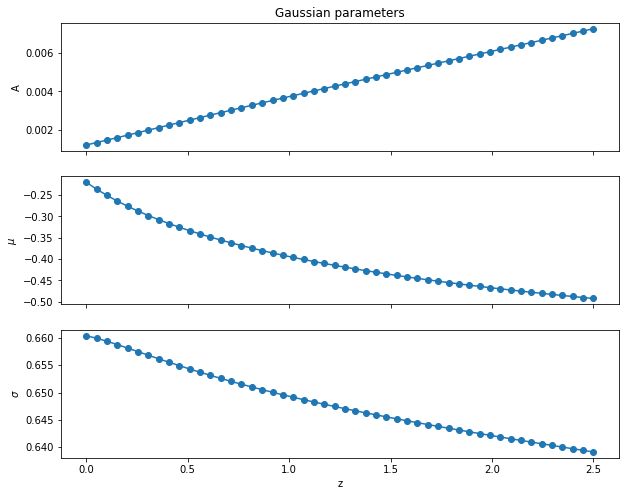

In [77]:
del f
f, axarr = plt.subplots(3, sharex=True,figsize=(10,8))
axarr[0].plot(redshifts, Aopt,'o-')
axarr[0].set_title('Gaussian parameters')
axarr[0].set(ylabel="A")
axarr[1].plot(redshifts,muopt,'o-')
axarr[1].set(ylabel="$\mu$")
axarr[2].plot(redshifts,sigmaopt,'o-')
axarr[2].set(xlabel="z",ylabel="$\sigma$")
plt.show()

I'm saving this data to a file so that it can be interpolated from whenever necessary. Of course, it might be better to use more data points but that ccan be done at a later stage when I've accouted for numerical errors in other steps

In [83]:
datatab = Table()
datatab['z'] = redshifts
datatab['A'] = Aopt
datatab['mu'] = muopt
datatab['sigma'] = sigmaopt

filename = '/home/sunil/Python/MgIIabs/MgIIabs/data/gauss_params.csv'
datatab.write(filename,format="ascii.csv")

In [86]:
#Testing if table is written properly
Table.read(filename,format="ascii.csv")

z,A,mu,sigma
float64,float64,float64,float64
0.0,0.00121304195862,-0.220585400782,0.660400286109
0.0510204081633,0.00133981900472,-0.236712628223,0.659941807
0.102040816327,0.00146793790889,-0.251259851127,0.65938766058
0.15306122449,0.00159709721171,-0.264502783199,0.658777771092
0.204081632653,0.00172702305442,-0.276651933702,0.658137852476
0.255102040816,0.00185746999983,-0.287870981262,0.657484702218
0.30612244898,0.00198822077526,-0.298289266548,0.656829465476
0.357142857143,0.00211908533769,-0.308010389351,0.65617953998
0.408163265306,0.00224989252788,-0.317121358531,0.655541305463


## Evaluating the integral

Now that we have the fit parameters, the integral is simply an error function. We can write a simple function to read the values from the disk, interpolate and get the integral. This has been done in the `absdistrib` module

### Testing spline interpolation

In [99]:
x = datatab['z'].data
y = np.array([datatab['A'].data, datatab['mu'].data, datatab['sigma'].data])
spline_interp=interp.interp1d(x,y,kind="cubic")
A,mu,sigma = spline_interp(z)
A, mu, sigma

(0.0072684318452921797, -0.49202553626916312, 0.63911422608146917)

In [4]:
rew = 0.1*u.nm
z = 0
growthf = gf.growfunc_z(z)
ad.d2ndWdl(rew,z,growthf)

<Quantity 0.0012130419363258476 1 / (Mpc nm)>

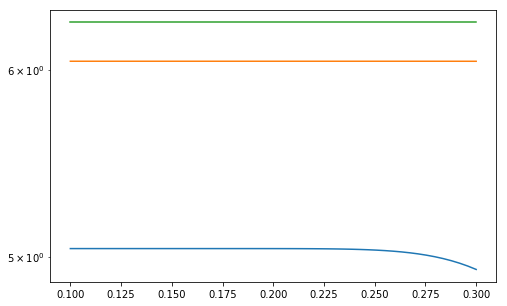

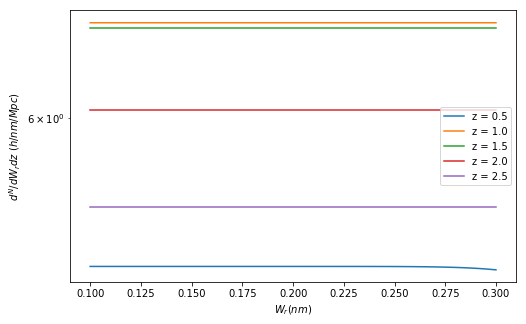

In [7]:
z = np.linspace(0.5,2.5,5)
rews = np.linspace(0.1,0.3)*u.nm
fig = plt.figure(figsize=(8,5))
for red in z:
    distriblist = []
    for rew in rews:
        distriblist.append(ad.d2ndWdz(rew,red).value)
    plt.semilogy(rews.value,distriblist,label="z = {:1.1f}".format(red))
plt.legend()
plt.ylabel(r"$d^N/dW_rdz$ $(h/nm/Mpc)$")
plt.xlabel(r'$W_r (nm)$')
plt.show()

This is in complete disagreement with the observations of Zhu-Menard (who propose an exponential form). I'm inserting it here for comparison: ![title](zhu_d2Ndwdz.png)

## $dN/dz$

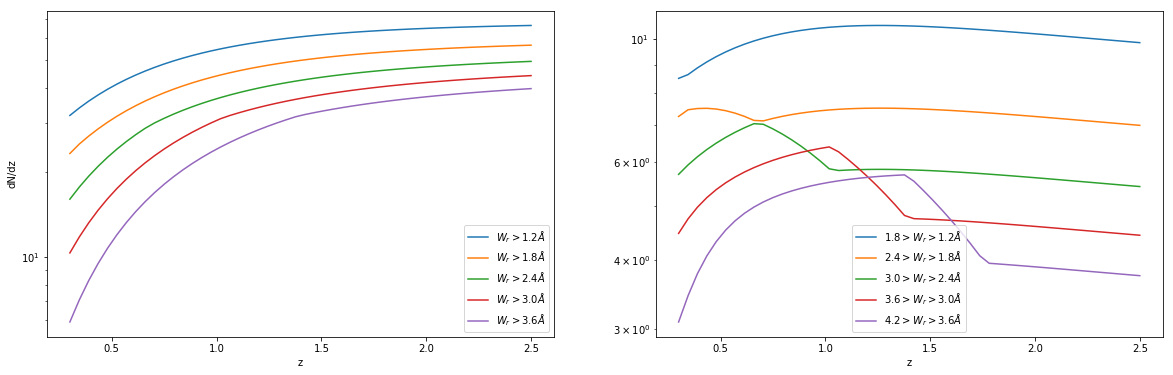

In [2]:
# For REW intervals
redshifts = np.linspace(0.3,2.5)
rew_mins = np.array([0.12,0.18,0.24,0.3,0.36])*u.nm
rew_maxes = np.array([0.18,0.24,0.3,0.36,0.42])*u.nm

fig, axes = plt.subplots(1,2,figsize=(20,6))
minplots = []
intervalplots = []
for index, rew in enumerate(rew_mins):
    dndzlist = [ad.dNdz(z,rew).value for z in redshifts]
    axes[0].semilogy(redshifts,dndzlist,label =r'$W_r>{:1.1f} \AA$'.format(rew.value*10))
    
    dndzlist = [ad.dNdz(z,rew,rew_maxes[index]) for z in redshifts]
    axes[1].semilogy(redshifts,dndzlist,label=r'${:1.1f}>W_r>{:1.1f} \AA$'.format(rew_maxes[index].value*10,rew.value*10))

axes[0].set(xlabel="z",ylabel="dN/dz")
axes[1].set(xlabel="z")
axes[0].legend()
axes[1].legend()
plt.show()

We can compare it against Zhu and Menard's figure. The shape of the functions is different and also there is some sort of difference in normalization but the ordering of the plot seems to be preserved![dNdz](zhu_dndz.png)

## Scaling the dN/dz

There is a clear difference in the normalization of Zhu-Menard's data and my results. I shall try to use a single scaling parameter (esentially a multiplier) to try and fit for a particular REW, say 0.1 nm.

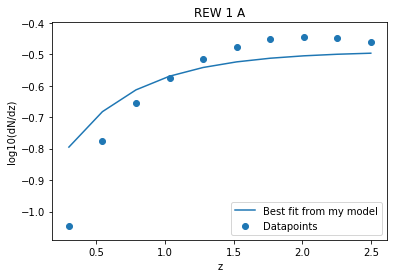

In [23]:
redshifts = np.linspace(0.3,2.5,10)
def scaled_dndz(red,a):
    return a*np.log10(ad.dNdz(red,0.1*u.nm).value)

g0 = 0.63
alpha_g = 5.38
z_g = 0.41
beta_g = 2.97
W0 = 0.33
alpha_W = 1.21
z_W = 2.24
beta_W = 2.43

dg0 = 0.39
dalpha_g = 1.08
dzg = 0.06
dbeta_g = 0.59
dW0 = 0.03
dalpha_w = 0.19
dz_w = 0.28
dbeta_w = 0.25

#And now the functions:
def g (z,g0,alpha_g,z_g,beta_g) :
    return g0*((1+z)**alpha_g)/(1+(z/z_g)**beta_g)
def Wstar (z,W0,alpha_W,z_W,beta_W):
    return W0*((1+z)**alpha_W)/(1+(z/z_W)**beta_W)
def zhu_dNdz (z, W,g0,alpha_g,z_g,beta_g,W0,alpha_W,z_W,beta_W) :
    return g(z,g0,alpha_g,z_g,beta_g)*Wstar(z,W0,alpha_W,z_W,beta_W)*np.exp(-W/Wstar(z,W0,alpha_W,z_W,beta_W))

datapoints = np.log10(zhu_dNdz(redshifts,1,g0,alpha_g,z_g,beta_g,W0,alpha_W,z_W,beta_W))
#pdb.set_trace()
#popt, pcov = curve_fit(scaled_dndz,redshifts,datapoints,p0=0.001)

fit_curve = [np.log10(0.0045*ad.dNdz(z,0.1*u.nm).value) for z in redshifts]
plt.figure()
plt.scatter(redshifts,datapoints,label="Datapoints")
plt.plot(redshifts,fit_curve,label="Best fit from my model")
plt.legend()
plt.xlabel("z")
plt.ylabel("log10(dN/dz)")
plt.title("REW 1 A")
plt.show()

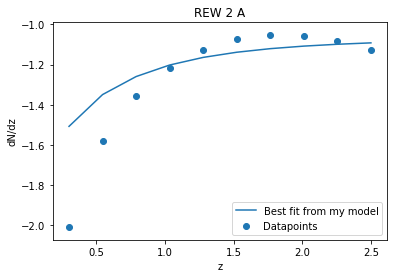

In [24]:
datapoints = np.log10(zhu_dNdz(redshifts,2))
#pdb.set_trace()
#popt, pcov = curve_fit(scaled_dndz,redshifts,datapoints,p0=0.001)

fit_curve = [np.log10(0.0015*ad.dNdz(z,0.2*u.nm).value) for z in redshifts]
plt.figure()
plt.scatter(redshifts,datapoints,label="Datapoints")
plt.plot(redshifts,fit_curve,label="Best fit from my model")
plt.legend()
plt.xlabel("z")
plt.ylabel("dN/dz")
plt.title("REW 2 A")
plt.show()

## Performance issues

In [16]:
cProfile.run("np.log(10)*quad(integrand,M_low,M_high)[0]")
#integral = np.log(10)*quad(integrand,M_low,M_high)[0]

         8975518 function calls (8898040 primitive calls) in 31.853 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    15450    0.031    0.000    0.073    0.000 <frozen importlib._bootstrap>:995(_handle_fromlist)
      147    0.012    0.000   31.852    0.217 <ipython-input-11-a947a44eeddb>:1(integrand)
        1    0.000    0.000   31.853   31.853 <string>:1(<module>)
      147    0.008    0.000    0.016    0.000 _fitpack_impl.py:317(splrep)
      147    0.003    0.000    0.008    0.000 _fitpack_impl.py:526(splev)
     6990    0.012    0.000    0.151    0.000 _methods.py:31(_sum)
   525306    0.478    0.000    0.478    0.000 _weakrefset.py:70(__contains__)
   331806    0.762    0.000    1.241    0.000 abc.py:178(__instancecheck__)
      147    0.003    0.000    0.004    0.000 const.py:27(initializecosmo)
      147    0.001    0.000    0.001    0.000 constant.py:139(__quantity_subclass__)
      441    0.000    0.000    0.00

    60975    0.144    0.000    0.213    0.000 six.py:580(iteritems)
     1323    0.005    0.000    0.005    0.000 transfunction.py:11(zeq)
      441    3.454    0.008    5.079    0.012 transfunction.py:111(Tbaryon)
      441    0.008    0.000    0.008    0.000 transfunction.py:120(Gfunc)
      441    0.043    0.000    8.502    0.019 transfunction.py:139(transfunction)
     2646    0.012    0.000    0.012    0.000 transfunction.py:19(keq)
     1323    0.011    0.000    0.011    0.000 transfunction.py:27(zdrag)
     2205    0.005    0.000    0.005    0.000 transfunction.py:39(ratiob2p)
      882    0.038    0.000    0.052    0.000 transfunction.py:47(soundhorizon)
      441    0.002    0.000    0.002    0.000 transfunction.py:60(ksilk)
      441    0.295    0.001    0.295    0.001 transfunction.py:70(j_0)
     1323    3.853    0.003    3.863    0.003 transfunction.py:77(Ttilde)
      441    0.777    0.002    3.380    0.008 transfunction.py:89(Tcdm)
    25641    0.217    0.000    0.486   

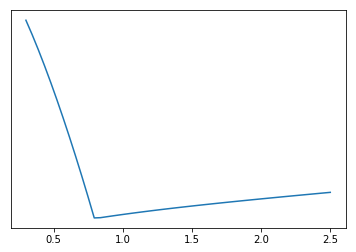

In [6]:
redshifts = np.linspace(0.3,2.5)
dndzlist = [ad.dNdz(z,rew_min=0.15*u.nm,rew_max=0.26*u.nm) for z in redshifts]
plt.semilogy(redshifts,dndzlist)
plt.show()

In [3]:
hmod.lowest_mass(rew=0.1*u.nm,z=1,low=3)

<Quantity 1749320.2255893906 solMass>

In [ ]:
hmod.rg(M=)